In [1]:
# Cell 1: Import necessary libraries
import os
import zipfile
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [6]:
# Cell 2: Extract the uploaded dataset
zip_path = "under_water_trash.zip" 
extract_path = "ocean_waste_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted to:", extract_path)


Dataset extracted to: ocean_waste_dataset


In [7]:
# Cell 3: List extracted files and folders
for root, dirs, files in os.walk(extract_path):
    print(root, "->", len(files), "files")


ocean_waste_dataset -> 0 files
ocean_waste_dataset\test -> 3433 files
ocean_waste_dataset\train -> 17160 files
ocean_waste_dataset\val -> 2460 files


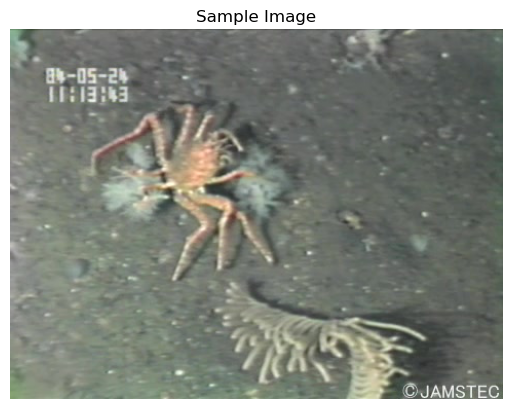

In [10]:
# Cell 4: Load and show a sample image
sample_folder = os.path.join(extract_path, os.listdir(extract_path)[0])
sample_file = os.path.join(sample_folder, os.listdir(sample_folder)[0])

img = Image.open(sample_file)
plt.imshow(img)
plt.title("Sample Image")
plt.axis("off")
plt.show()


In [12]:
# Cell 5: Define constants
IMG_SIZE = (128, 128)
BATCH_SIZE = 32
EPOCHS = 15


In [14]:
# Cell 6: Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = train_datagen.flow_from_directory(
    extract_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="training"
)

val_gen = train_datagen.flow_from_directory(
    extract_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="binary",
    subset="validation"
)


Found 6148 images belonging to 3 classes.
Found 1536 images belonging to 3 classes.


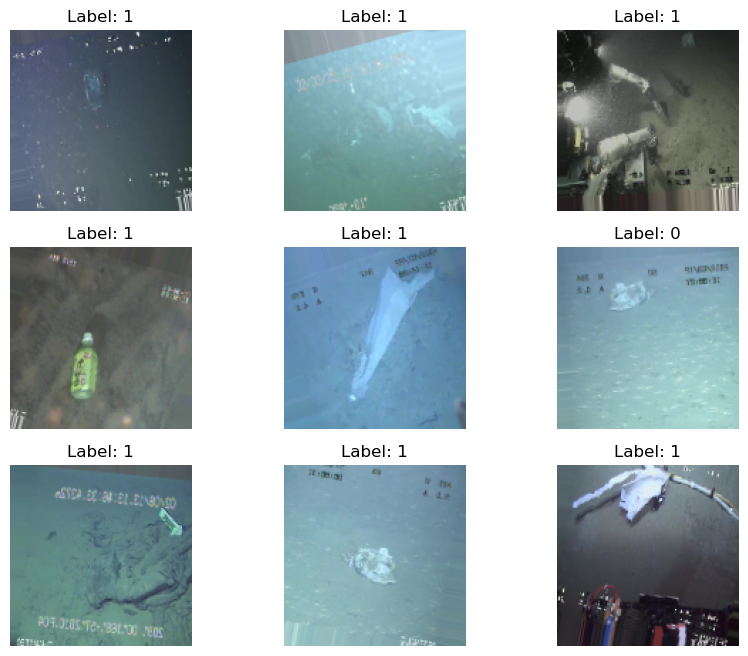

In [16]:
# Cell 7: Visualize a few training images
images, labels = next(train_gen)
plt.figure(figsize=(10, 8))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")
    plt.axis("off")
plt.show()


In [18]:
# Cell 8: Define CNN model
def build_model(input_shape):
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model((IMG_SIZE[0], IMG_SIZE[1], 3))
model.summary()


C:\Users\Lata\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Cell 9: Train CNN
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS
)


C:\Users\Lata\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.7402 - loss: 0.6689 - val_accuracy: 0.7448 - val_loss: 14.1245
Epoch 2/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 95s 493ms/step - accuracy: 0.7443 - loss: 0.0638 - val_accuracy: 0.7448 - val_loss: 0.2373
Epoch 3/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 108s 561ms/step - accuracy: 0.7443 - loss: 0.2559 - val_accuracy: 0.7448 - val_loss: 0.2885
Epoch 4/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 119s 616ms/step - accuracy: 0.7443 - loss: 0.2122 - val_accuracy: 0.7448 - val_loss: 0.7400
Epoch 5/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 102s 527ms/step - accuracy: 0.7443 - loss: 0.1067 - val_accuracy: 0.7448 - val_loss: 3.4885
Epoch 6/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 97s 502ms/step - accuracy: 0.7428 - loss: 2.2274 - val_accuracy: 0.7448 - val_loss: 29.4372
Epoch 7/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 99s 514ms/step - accuracy: 0.7443 - loss: 1.8142 - val_accuracy: 0.7448 - val_loss: 0.5604
Epoch 8/15
193/193 ━━━━━━━━━━━━━━━━━━━━ 97s 502ms/step - accuracy: 0.7443 - loss

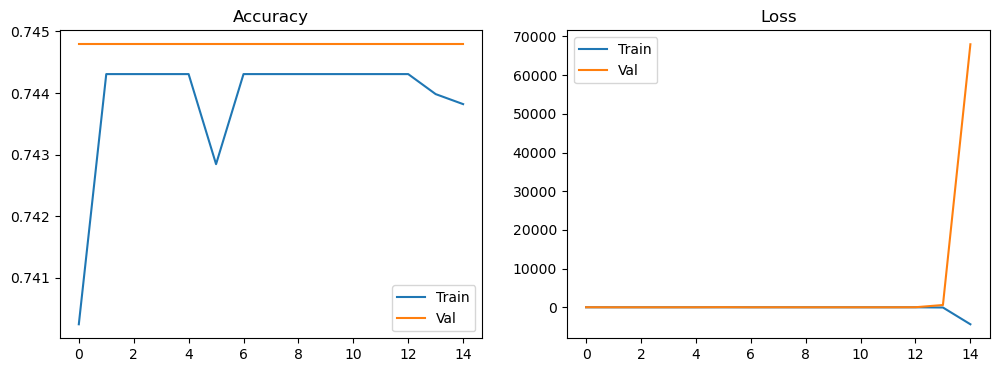

In [24]:
# Cell 10: Plot training results
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title('Loss')
plt.legend()
plt.show()


In [26]:
# Cell 11: Save model
model.save("ocean_waste_cnn_model.h5")
print("Model saved successfully!")


Model saved successfully!


In [28]:
# Cell 12: Evaluate model
val_loss, val_acc = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_acc:.3f}")


48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 346ms/step - accuracy: 0.7448 - loss: 68211.4531
Validation Accuracy: 0.745


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Prediction: Waste Detected


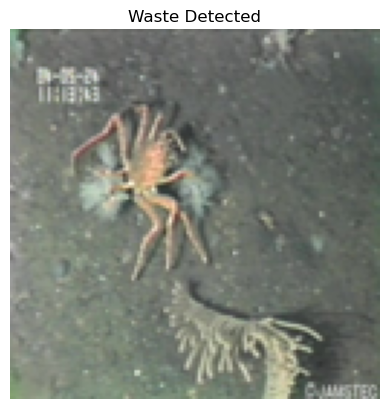

In [30]:
# Cell 13: Predict on single image
test_img_path = sample_file  # you can change this path
img = Image.open(test_img_path).convert("RGB").resize(IMG_SIZE)
img_arr = np.expand_dims(np.array(img)/255.0, axis=0)

pred = model.predict(img_arr)[0][0]
label = "Waste Detected" if pred > 0.5 else "Clean Ocean"
print("Prediction:", label)

plt.imshow(img)
plt.title(label)
plt.axis("off")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


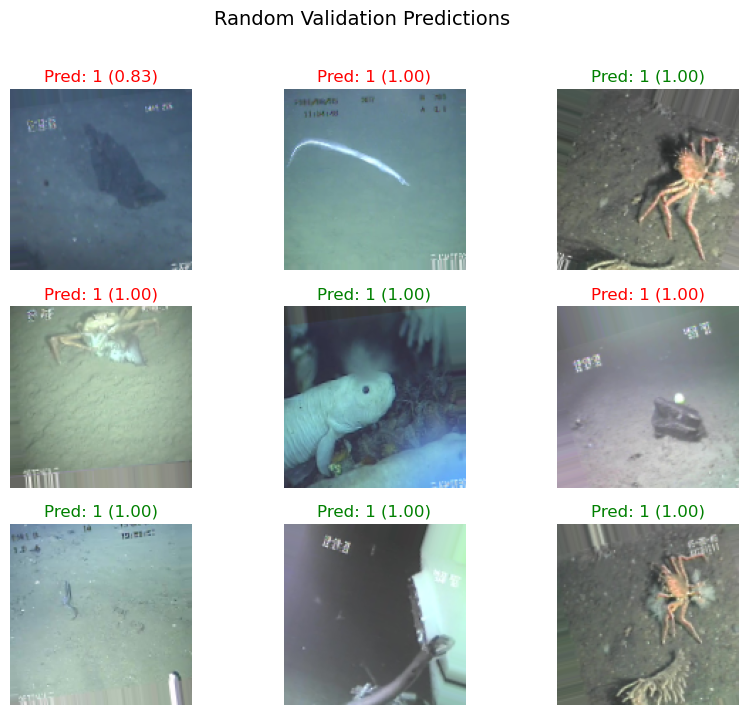

In [40]:
# Cell 13.1: Predict on multiple random validation images

import random

# Pick random batch from validation set
val_images, val_labels = next(val_gen)
indices = random.sample(range(len(val_images)), 9)

plt.figure(figsize=(10, 8))
for i, idx in enumerate(indices):
    img = val_images[idx]
    true_label = int(val_labels[idx])
    pred_prob = model.predict(np.expand_dims(img, axis=0))[0][0]
    pred_label = 1 if pred_prob > 0.5 else 0

    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    color = "green" if pred_label == true_label else "red"
    plt.title(f"Pred: {pred_label} ({pred_prob:.2f})", color=color)
    plt.axis("off")

plt.suptitle("Random Validation Predictions", fontsize=14)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step


C:\Users\Lata\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Lata\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


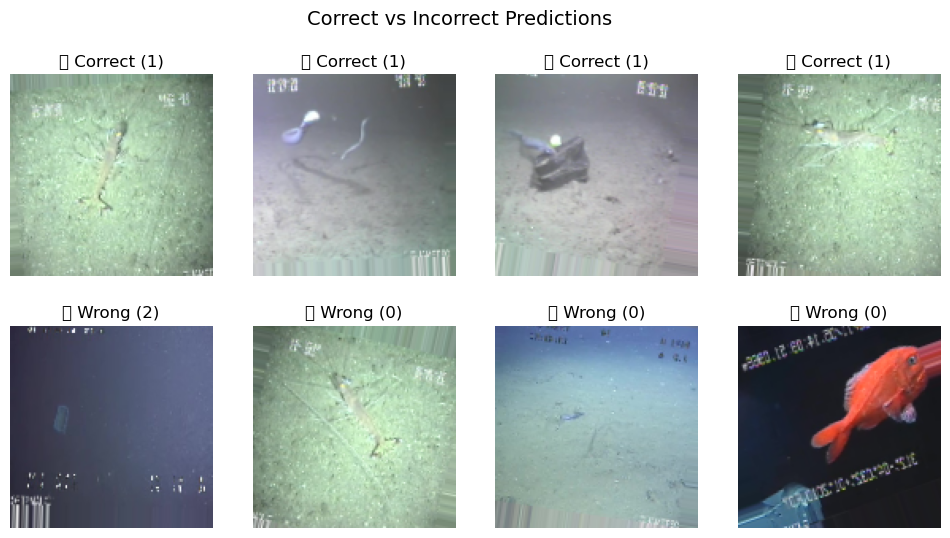

In [42]:
# Cell 13.2: Show correct and incorrect predictions separately

val_gen.reset()
val_images, val_labels = next(val_gen)
preds = (model.predict(val_images) > 0.5).astype("int32").flatten()

correct_idx = [i for i in range(len(preds)) if preds[i] == val_labels[i]]
incorrect_idx = [i for i in range(len(preds)) if preds[i] != val_labels[i]]

# Display 4 correct and 4 incorrect predictions
plt.figure(figsize=(12,6))
for i, idx in enumerate(correct_idx[:4]):
    plt.subplot(2,4,i+1)
    plt.imshow(val_images[idx])
    plt.title(f"✅ Correct ({int(val_labels[idx])})")
    plt.axis("off")

for i, idx in enumerate(incorrect_idx[:4]):
    plt.subplot(2,4,i+5)
    plt.imshow(val_images[idx])
    plt.title(f"❌ Wrong ({int(val_labels[idx])})")
    plt.axis("off")

plt.suptitle("Correct vs Incorrect Predictions", fontsize=14)
plt.show()


48/48 ━━━━━━━━━━━━━━━━━━━━ 17s 361ms/step


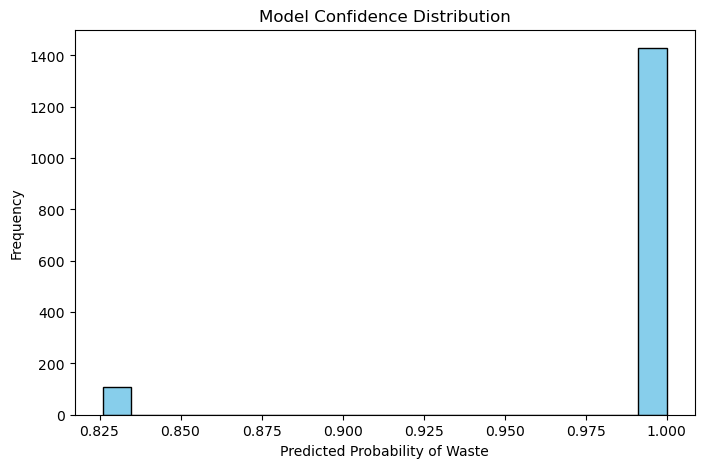

In [44]:
# Cell 13.3: Plot model confidence distribution

val_gen.reset()
pred_probs = model.predict(val_gen).flatten()

plt.figure(figsize=(8,5))
plt.hist(pred_probs, bins=20, color='skyblue', edgecolor='black')
plt.title("Model Confidence Distribution")
plt.xlabel("Predicted Probability of Waste")
plt.ylabel("Frequency")
plt.show()


48/48 ━━━━━━━━━━━━━━━━━━━━ 15s 313ms/step


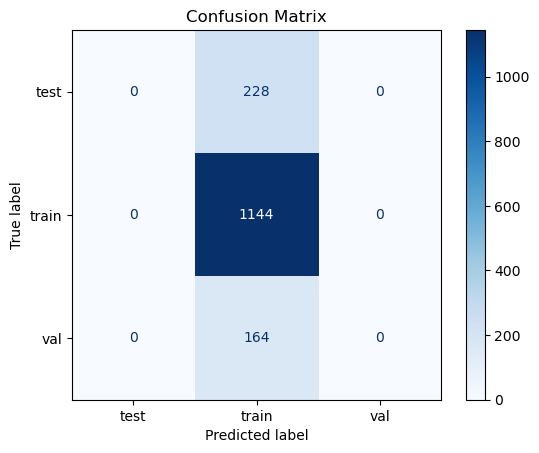

In [34]:
# Cell 14 (fixed): Confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Reset generator and collect true + predicted labels
val_gen.reset()
y_true = val_gen.classes
y_pred = (model.predict(val_gen) > 0.5).astype("int32").flatten()

# Get correct class labels from the generator
class_labels = list(val_gen.class_indices.keys())

# Compute and display confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


Training plots saved!


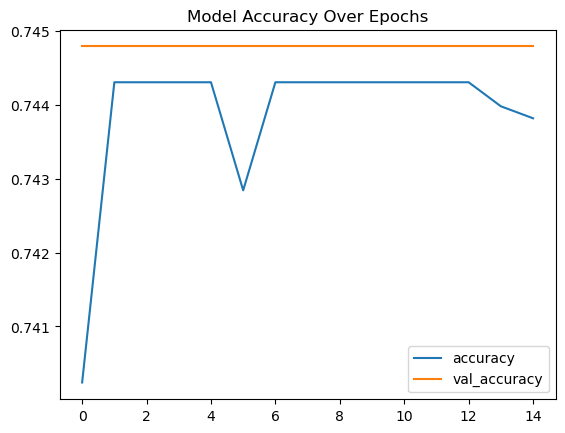

In [36]:
# Cell 15: Save training history plots
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.title("Model Accuracy Over Epochs")
plt.savefig("training_accuracy.png")
print("Training plots saved!")


In [38]:
# Cell 16: Summary cell
print("Ocean Waste Detection Completed!")
print("Final Validation Accuracy:", round(val_acc*100, 2), "%")
print("You can now use ocean_waste_cnn_model.h5 for prediction or deployment.")


Ocean Waste Detection Completed!
Final Validation Accuracy: 74.48 %
You can now use ocean_waste_cnn_model.h5 for prediction or deployment.
